In [43]:

import itertools

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.noise import AlphaDropout
from keras import optimizers
from keras import layers
import tensorflow as tf

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import linear_model, tree, ensemble

# Modeling
import lightgbm as lgb
# Splitting data
from sklearn.model_selection import train_test_split

N_FOLDS = 5
MAX_EVALS = 5


In [28]:
cdf=pd.read_csv("/content/drive/MyDrive/Data/ClinicalTrialData.csv")
cdf.head(5)

,dkey,ikey,tid,outcome,taracc,idsi,route.1,route.10,route.17,origin.6,...,loc.67,loc.8,loc.10,loc.11,loc.23,loc.25,loc.26,loc.30,loc.32,loc.68
0,32780,867,71421,0,198,7,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,16453,429,5946,1,330,22,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,32739,890,83628,0,30,2,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,24737,110,90383,1,120,49,0,0,1,0,...,0,0,0,1,0,1,1,0,1,1
4,24737,110,136920,1,70,14,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
cdf.columns

Index(['dkey', 'ikey', 'tid', 'outcome', 'taracc', 'idsi', 'route.1',
       'route.10', 'route.17', 'origin.6', 'origin.25', 'medium.8',
       'medium.12', 'medium.13', 'medium.14', 'medium.25', 'priorapp', 'dkw.1',
       'dkw.2', 'dkw.3', 'dkw.4', 'dkw.5', 'dkw.6', 'dkw.13', 'dkw.14',
       'dkw.16', 'dkw.18', 'dkw.24', 'dkw.25', 'stid.1', 'stid.2', 'stid.3',
       'stid.8', 'stid.31', 'loc.2', 'loc.3', 'loc.67', 'loc.8', 'loc.10',
       'loc.11', 'loc.23', 'loc.25', 'loc.26', 'loc.30', 'loc.32', 'loc.68'],
      dtype='object')

In [30]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1326 entries, 0 to 1325
Data columns (total 46 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   dkey       1326 non-null   int64
 1   ikey       1326 non-null   int64
 2   tid        1326 non-null   int64
 3   outcome    1326 non-null   int64
 4   taracc     1326 non-null   int64
 5   idsi       1326 non-null   int64
 6   route.1    1326 non-null   int64
 7   route.10   1326 non-null   int64
 8   route.17   1326 non-null   int64
 9   origin.6   1326 non-null   int64
 10  origin.25  1326 non-null   int64
 11  medium.8   1326 non-null   int64
 12  medium.12  1326 non-null   int64
 13  medium.13  1326 non-null   int64
 14  medium.14  1326 non-null   int64
 15  medium.25  1326 non-null   int64
 16  priorapp   1326 non-null   int64
 17  dkw.1      1326 non-null   int64
 18  dkw.2      1326 non-null   int64
 19  dkw.3      1326 non-null   int64
 20  dkw.4      1326 non-null   int64
 21  dkw.5      132

We can see that there is no null data present. 

Text(0.5, 1.05, 'Correlation of WBCD Features')

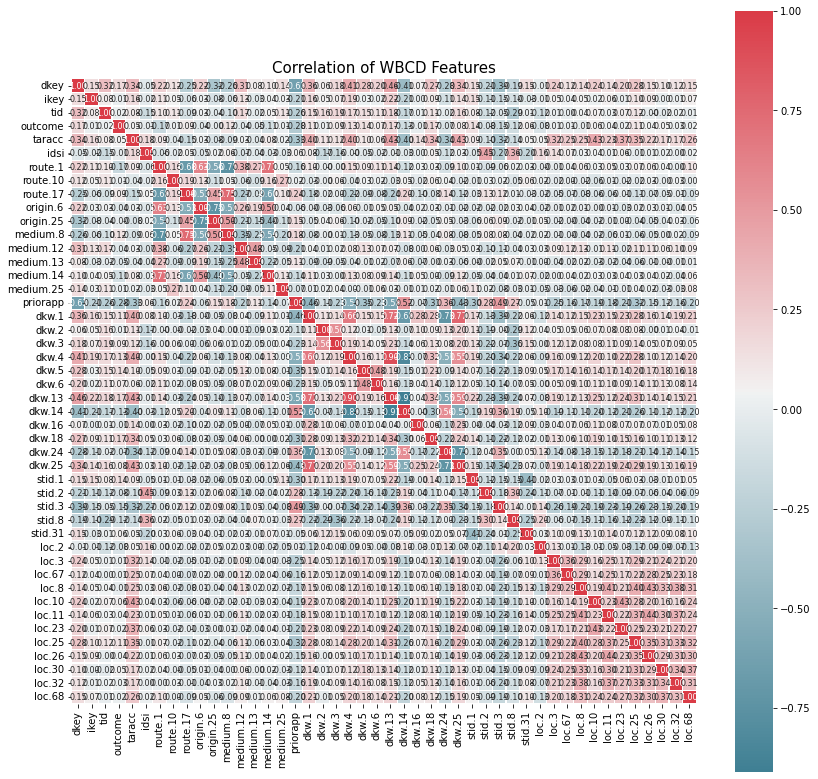

In [31]:
import seaborn as sns 
from matplotlib import pyplot as plt

corr=cdf.corr()
colormap = sns.diverging_palette(220, 10, as_cmap = True)
plt.figure(figsize=(14,14))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 8},
            cmap = colormap, linewidths=0.1, linecolor='white')
plt.title('Correlation of WBCD Features', y=1.05, size=15)

In [32]:
positive=cdf[cdf["outcome"]==1]
negative=cdf[cdf["outcome"]==0]
print("Positive:" ,positive.shape[0],"Negative: ",negative.shape[0])
cdf=pd.concat([positive,positive,negative,positive,positive,negative])
cdf.shape

Positive: 248 Negative:  1078


(3148, 46)

The data is imbalanced and of medium size. Hence I have used k-fold stratified cross validation.
For data augmentation I have done upsampling of data belonging to minority class. So the whole dataset has 3148 points and 46 features.

We have an imbalanced dataset hence I have used F1 score and ROC AUC score for evaluation metrics rather than using Accuracy score.


For data representation, I used PCA dimension reduction technique to check the desstibution of data and see if clustering can help.

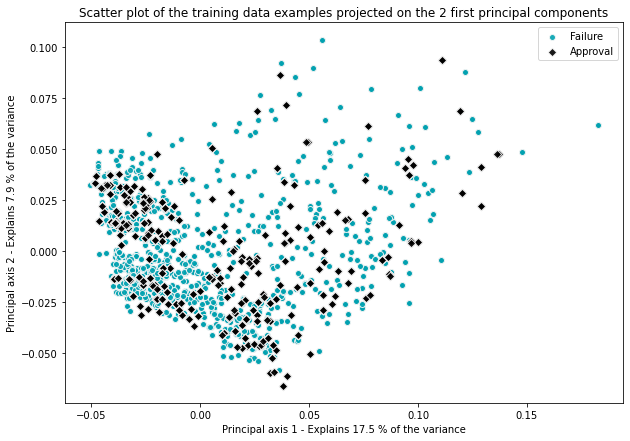

In [33]:
y_train = cdf["outcome"]
x_train = cdf.drop(labels=["outcome","dkey","ikey","tid"], axis=1)
classes = np.sort(np.unique(y_train))
labels = ["Failure", "Approval"]

# Normalize each feature to unit norm (vector length)
x_train_normalized = normalize(x_train, axis=0)

# Run PCA
pca = PCA(n_components=2)
x_train_projected = pca.fit_transform(x_train_normalized)

# Visualize
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1)
colors = [(0.0, 0.63, 0.69), 'black']
markers = ["o", "D"]
for class_ix, marker, color, label in zip(
        classes, markers, colors, labels):
    ax.scatter(x_train_projected[np.where(y_train == class_ix), 0],
                x_train_projected[np.where(y_train == class_ix), 1],
                marker=marker, color=color, edgecolor='whitesmoke',
                linewidth='1', alpha=0.9, label=label)
    ax.legend(loc='best')
plt.title(
    "Scatter plot of the training data examples projected on the "
    "2 first principal components")
plt.xlabel("Principal axis 1 - Explains %.1f %% of the variance" % (
    pca.explained_variance_ratio_[0] * 100.0))
plt.ylabel("Principal axis 2 - Explains %.1f %% of the variance" % (
    pca.explained_variance_ratio_[1] * 100.0))
plt.show()

We can see that the data points are scattered across uniformaly and hence I did not use SMOTE technique for data augmentation.



In [34]:
y = cdf["outcome"]
X = cdf.drop(labels=["outcome","dkey","ikey","tid"], axis=1)


kf =KFold(n_splits=5, shuffle=True, random_state=42)

cnt = 1
# split()  method generate indices to split data into training and test set.
for train_index, test_index in kf.split(X, y):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt += 1

Fold:1, Train set: 2518, Test set:630
Fold:2, Train set: 2518, Test set:630
Fold:3, Train set: 2518, Test set:630
Fold:4, Train set: 2519, Test set:629
Fold:5, Train set: 2519, Test set:629


I tried different machine learning models like Neural Networks, Random Forest and LightGradientBoosting techniques and found out that LGB models wokr the best on given data

In [35]:
loc_cols=[]

for i in cdf.columns:
  if "loc" in i:
    loc_cols.append(i)
print(loc_cols)

['loc.2', 'loc.3', 'loc.67', 'loc.8', 'loc.10', 'loc.11', 'loc.23', 'loc.25', 'loc.26', 'loc.30', 'loc.32', 'loc.68']


In [36]:
y = cdf["outcome"]
X = cdf.drop(labels=["outcome","dkey","ikey","tid",'loc.2', 'loc.3', 'loc.67', 'loc.8', 'loc.10', 'loc.11', 'loc.23', 'loc.25', 'loc.26', 'loc.30', 'loc.32', 'loc.68']\
             , axis=1)

kf =KFold(n_splits=5, shuffle=True, random_state=42)

cnt = 1
# split()  method generate indices to split data into training and test set.
for train_index, test_index in kf.split(X, y):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt += 1

Fold:1, Train set: 2518, Test set:630
Fold:2, Train set: 2518, Test set:630
Fold:3, Train set: 2518, Test set:630
Fold:4, Train set: 2519, Test set:629
Fold:5, Train set: 2519, Test set:629


In [37]:
n_estimators = [50,100,150,200,300]

for val in n_estimators:
    score = cross_val_score(ensemble.RandomForestClassifier(n_estimators= val, random_state= 42), X, y, cv= kf, scoring="f1")
    print(f'Average score({val}): {"{:.3f}".format(score.mean())}')
  


Average score(50): 0.971
Average score(100): 0.972
Average score(150): 0.972
Average score(200): 0.972
Average score(300): 0.970


In [38]:
model=ensemble.RandomForestClassifier(n_estimators= 200, random_state= 42)
model.fit(X,y)


RandomForestClassifier(n_estimators=200, random_state=42)

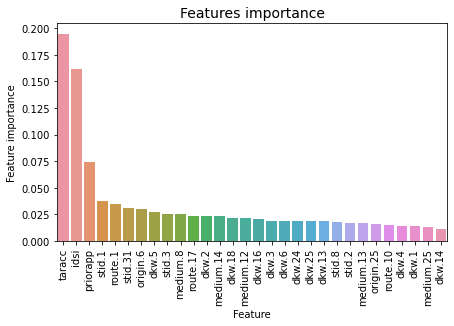

In [39]:
from matplotlib import pyplot as plt
tmp = pd.DataFrame({'Feature': X.columns, 'Feature importance': model.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

In [41]:



def get_callbacks( patience_lr):
    reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.01, patience=patience_lr, verbose=1, epsilon=1e-4, mode='min')
    return [reduce_lr_loss]

model = Sequential()
model.add(Dense(64, input_dim=30, activation='elu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='elu'))
model.add(Dropout(0.2))

model.add(Dense(16, activation='elu'))
model.add(Dense(1, activation='sigmoid'))

opt = optimizers.Adadelta(lr=.05)
recall=tf.keras.metrics.Recall(
)
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=[recall])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                1984      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,609
Trainable params: 4,609
Non-traina

20/20 [==============================] - 0s 2ms/step - loss: 0.4551 - recall_1: 0.5678
[0.45509564876556396, 0.5678392052650452]
20/20 [==============================] - 0s 5ms/step - loss: 0.3258 - recall_1: 0.6533
[0.32581406831741333, 0.6532663106918335]
20/20 [==============================] - 0s 2ms/step - loss: 0.2557 - recall_1: 0.9040
[0.2556982636451721, 0.9040403962135315]
20/20 [==============================] - 0s 5ms/step - loss: 0.2702 - recall_1: 0.7525
[0.2701815366744995, 0.752525269985199]
20/20 [==============================] - 0s 2ms/step - loss: 0.1801 - recall_1: 0.9293
[0.18014273047447205, 0.9292929172515869]


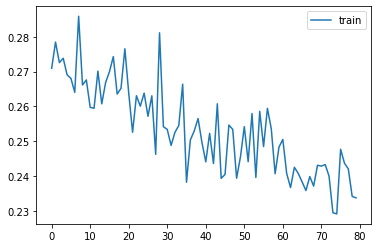

In [42]:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
    
callbacks = get_callbacks(patience_lr=10)
for (train, test), i in zip(cv.split(X, y), range(5)):
    history=model.fit(X.iloc[train], y.iloc[train],epochs=80,verbose=False)
    pred=model.predict(X.iloc[test])

    print(model.evaluate(X.iloc[test], y.iloc[test]))

plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

In [ ]:
n_estimators = [50,300,400,600,700]

for val in n_estimators:
    clf=ensemble.RandomForestClassifier(n_estimators= val,max_depth=15,max_features=10, random_state= 42)
    score = cross_val_score(clf, X, y, cv= kf, scoring="f1")
    print(f'Average score({val}): {"{:.3f}".format(score.mean())}')
    # print(clf.feature_importances_)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
learning_rates = [ 0.50,0.60,0.65,0.80,0.77, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=200,learning_rate = learning_rate, max_features=10, max_depth =15, random_state = 0)
    score = cross_val_score(gb, X, y, cv= kf, scoring="f1")
    print(f'Average score({val}): {"{:.3f}".format(score.mean())}')
    # gb.fit(X_train_sub, y_train_sub)

In [44]:
labels=cdf["outcome"]
features=cdf.drop(labels=["outcome","dkey","ikey","tid",'loc.2', 'loc.3', 'loc.67', 'loc.8', 'loc.10', 'loc.11', 'loc.23', 'loc.25', 'loc.26', 'loc.30', 'loc.32', 'loc.68']\
             , axis=1)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.30, random_state = 50,stratify=labels)

In [45]:
print("Training features shape: ", train_features.shape)
print("Testing features shape: ", test_features.shape)
train_features[:4]

Training features shape:  (2203, 30)
Testing features shape:  (945, 30)


,taracc,idsi,route.1,route.10,route.17,origin.6,origin.25,medium.8,medium.12,medium.13,...,dkw.14,dkw.16,dkw.18,dkw.24,dkw.25,stid.1,stid.2,stid.3,stid.8,stid.31
1033,12,4,0,0,1,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,1
798,126,1,0,0,1,1,0,1,0,0,...,1,0,0,0,1,0,0,1,0,1
76,135,5,1,0,1,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
887,16,1,1,0,1,1,0,1,0,1,...,0,0,0,0,1,0,0,0,0,1


In [46]:
train_set = lgb.Dataset(data = train_features, label = train_labels)
test_set = lgb.Dataset(data = test_features, label = test_labels)

In [47]:
model = lgb.LGBMClassifier()
default_params = model.get_params()


cv_results = lgb.cv(default_params, train_set, num_boost_round = 10000, early_stopping_rounds = 80, 
                    metrics = 'auc', nfold = N_FOLDS, seed = 42)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


In [48]:
print('The maximum validation ROC AUC was: {:.5f} with a standard deviation of {:.5f}.'.format(cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
print('The optimal number of boosting rounds (estimators) was {}.'.format(len(cv_results['auc-mean'])))

The maximum validation ROC AUC was: 0.95585 with a standard deviation of 0.01334.
The optimal number of boosting rounds (estimators) was 100.


In [49]:
# Optimal number of esimators found in cv
model.n_estimators = len(cv_results['auc-mean'])

# Train and make predicions with model
model.fit(train_features, train_labels)
preds = model.predict_proba(test_features)[:, 1]
baseline_auc = roc_auc_score(test_labels, preds)

print('The baseline model scores {:.5f} ROC AUC on the test set.'.format(baseline_auc))

The baseline model scores 0.97940 ROC AUC on the test set.


In [50]:
def objective(hyperparameters, iteration):
    """Objective function for grid and random search. Returns
       the cross validation score from a set of hyperparameters."""
    
    # Number of estimators will be found using early stopping
    if 'n_estimators' in hyperparameters.keys():
        del hyperparameters['n_estimators']
    
     # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 42)
    
    # results to retun
    score = cv_results['auc-mean'][-1]
    estimators = len(cv_results['auc-mean'])
    hyperparameters['n_estimators'] = estimators 
    
    return [score, hyperparameters, iteration]

In [51]:
score, params, iteration = objective(default_params, 1)

print('The cross-validation ROC AUC was {:.5f}.'.format(score))

The cross-validation ROC AUC was 0.97030.


In [52]:
param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(20, 150,10)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
}

In [53]:
import itertools

def grid_search(param_grid, max_evals = MAX_EVALS):
    """Grid search algorithm (with limit on max evals)"""
    
    # Dataframe to store results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))
    
    keys, values = zip(*param_grid.items())
    
    i = 0
    
    # Iterate through every possible combination of hyperparameters
    for v in itertools.product(*values):
        
        # Create a hyperparameter dictionary
        hyperparameters = dict(zip(keys, v))
        
        # Set the subsample ratio accounting for boosting type
        hyperparameters['subsample'] = 1.0 if hyperparameters['boosting_type'] == 'goss' else hyperparameters['subsample']
        
        # Evalute the hyperparameters
        eval_results = objective(hyperparameters, i)
        
        results.loc[i, :] = eval_results
        
        i += 1
        
        # Normally would not limit iterations
        if i > MAX_EVALS:
            break
       
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    
    return results

In [54]:
grid_results = grid_search(param_grid)

print('The best validation score was {:.5f}'.format(grid_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

import pprint
pprint.pprint(grid_results.loc[0, 'params'])


The best validation score was 0.96516

The best hyperparameters were:
{'boosting_type': 'gbdt',
 'colsample_bytree': 0.6,
 'is_unbalance': True,
 'learning_rate': 0.004999999999999999,
 'min_child_samples': 20,
 'n_estimators': 7436,
 'num_leaves': 20,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 0.5,
 'subsample_for_bin': 20000}


In [55]:
# Get the best parameters
grid_search_params = grid_results.loc[0, 'params']

# Create, train, test model
model = lgb.LGBMClassifier(**grid_search_params, random_state=42)
model.fit(train_features, train_labels)

preds = model.predict_proba(test_features)[:, 1]

print('The best model from grid search scores {:.5f} ROC AUC on the test set.'.format(roc_auc_score(test_labels, preds)))

The best model from grid search scores 0.98816 ROC AUC on the test set.


- Out fo the three models, LGB model performs the best with 0.98 roc auc score followed by Random Forest models with 0.97 and Neural Nets perform the worst.